# Tracking with DeepSORT

Multiple-Object Tracking (MOT) is a task in which, given a video and a class of objects, one attempts to track individual objects through time. The objective is to detect the position of objects in a video and associate the same object across frames.

As the performance of deep learning object detectors has increased, MOT algorithms have become increasingly reliant on the accuracy of the detections. 

In this tutorial, we will show you how to use the two basic MOT algorithms, Simple Online Realtime Tracking (SORT) and  Simple Online Realtime Tracking with a Deep Association Metric (DeepSORT), and compare their performance.

DeepSORT is a simple MOT algorithm that uses deep learning to learn a metric for comparing the appearance of objects. It is based on the SORT algorithm, which uses a Kalman Filter to track objects and an Hungarian algorithm for data association.

* [Simple Online and Realtime Tracking](https://arxiv.org/abs/1602.00763)
* [Simple Online and Realtime Tracking with a Deep Association Metric](https://arxiv.org/abs/1703.07402)

In [1]:
%load_ext autoreload
%autoreload 2

### Preparing the detection model 

Although the original paper uses the Faster Region CNN (FrRCNN) detection framework for object detection, we will use fine-tuned YOLOv5 models trained on the soccertrack drone dataset as it is faster and more accurate. The model checkpoints can be downloaded from [here](). Place them in the `models` folder and use the following code to load them.

YOLOv5 🚀 v6.2-239-gf33718f Python-3.9.14 torch-1.13.1 CPU

Fusing layers... 
Model summary: 267 layers, 46113663 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


,bbox_left,bbox_top,bbox_width,bbox_height,conf,class
0,2526.114258,525.223206,40.022705,40.100830,0.868529,0.000000
1,2307.825439,517.145508,39.808594,39.598511,0.864342,0.000000
2,2627.901611,802.629517,40.195312,40.360107,0.848603,0.000000
3,2520.891357,1362.365479,39.759277,39.991089,0.840663,0.000000
4,2238.303223,1118.072876,41.145264,40.639160,0.836599,0.000000


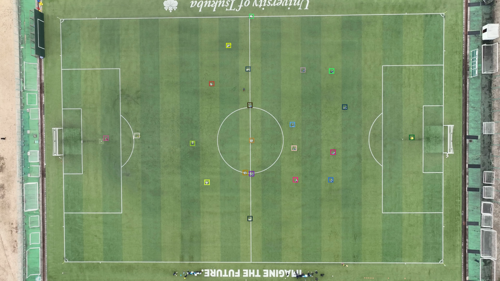

In [12]:
import soccertrack
from soccertrack import Camera, detection_model
from soccertrack.utils import get_git_root
from soccertrack.logger import show_df

root = get_git_root()
model_name = "yolov5"
model_repo = root / "external" / "yolov5"
model_ckpt = root / "models" / "yolov5" / "yolov5x_last.pt"
det_model = detection_model.load(model_name, model_repo, model_ckpt)

dataset_path = soccertrack.datasets.get_path("top-view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
cam = Camera(path_to_mp4)  # Camera object will be used to load frames
frame = cam.get_frame(0)[:, :, ::-1]  # Get first frame

det_model.model.conf = 0.01
det_model.model.size = 1920

det_result = det_model(frame, augment=True)

# take the top 22 detections
det_result.pred = det_result.pred[:22]

# Display the detections
show_df(det_result.to_df().head())

# Visualize the detections
im = det_result.show(width=5)
im.thumbnail((500, 500))
im

## Preparing the Appearance Model

In [6]:
from soccertrack.image_model import ImageEmbedder

dirpath = root / "models" / "resnet18"
ckpt_path = list(dirpath.glob('*.ckpt'))[-1]
image_model = ImageEmbedder.load_from_checkpoint(ckpt_path, num_classes=2)

### Preparing the Motion Model

Here we define the object model, i.e. the representation and the motion model used to propagate a target’s identity into the next frame. We use a Kalman filter to model the target’s motion.

In [13]:
import numpy as np
from soccertrack.detection_model.base import Detection
from soccertrack.tracking_model.tracker import MultiObjectTracker
from soccertrack.tracking_model.matching import EuclideanDistance

dt = 1/25
model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": 998.9,
    "r_var_pos": 0.0001,
    "q_var_size": 41.7,
    "r_var_size": 0.1,
    "p_cov_p0": 0.0012,
}


tracker = MultiObjectTracker(dt, model_spec=model_spec, matching_fn=EuclideanDistance(50))

### Tracking

In [15]:
from soccertrack.logger import tqdm, set_log_level
from soccertrack.utils.draw import draw_tracks

set_log_level('INFO')

for frame in (pbar := tqdm(cam.iter_frames())):
    
    # detect objects using the detection model
    detections = det_model(frame).to_list()
    
    # update the state of the multi-object-tracker tracker
    # with the list of bounding boxes
    tracker.step(detections=detections)
    
    tracks = tracker.active_tracks()
    pbar.set_postfix({f"Number of tracks": len(tracks)})

900it [02:50,  5.29it/s, Number of tracks=26]


In [20]:
bbdf_pred = tracker.to_bbdf()
bbdf_pred.sort_index(inplace=True)
print(bbdf_pred.shape)
bbdf_pred.head()

(899, 1375)


TeamID                0                                 ...               \
PlayerID   508569990744                                 ... 315839401078   
Attributes      bb_left bb_top bb_width bb_height conf  ...      bb_left   
frame                                                   ...                
1                   NaN    NaN      NaN       NaN  NaN  ...          NaN   
2                   NaN    NaN      NaN       NaN  NaN  ...          NaN   
3                   NaN    NaN      NaN       NaN  NaN  ...          NaN   
4                   NaN    NaN      NaN       NaN  NaN  ...          NaN   
5                   NaN    NaN      NaN       NaN  NaN  ...          NaN   

TeamID                                     
PlayerID                                   
Attributes bb_top bb_width bb_height conf  
frame                                      
1             NaN      NaN       NaN  NaN  
2             NaN      NaN       NaN  NaN  
3             NaN      NaN       NaN  NaN  
4             NaN      NaN       NaN  NaN  
5             NaN      NaN       NaN  NaN  

[5 rows x 1375 columns]

In [22]:
save_path = 'tracks.mp4'
set_log_level('ERROR')
bbdf_pred.visualize_frames(cam.video_path, save_path)

In [26]:
from IPython.display import Video

Video('tracks.mp4', width=800)

---